In [0]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

# MNIST dataset
# trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)

# Fashion MNIST dataset
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## transforms.Compose()
* ToTensor() : Converts PIL Image to a tensor. Value range [0, 255] --> [0, 1]
* Normalize(mean , std) : Normalizes data of each channel according to mean and standard deviation provided

In [0]:
class Classifier(nn.Module):
    
  def __init__(self):
    
    super().__init__()
    self.fc1 = nn.Linear(784, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)
  
    self.dropout = nn.Dropout(p=0.3)
  def forward(self, x):
    
    x = x.view(x.shape[0], -1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.dropout(F.relu(self.fc4(x)))
    x = F.log_softmax(self.fc5(x), dim=1)

    return x

In [69]:
model = Classifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr = 0.01, lr_decay = 1e-3)
images, labels = next(iter(trainloader))

epochs = 15
train_log, test_log = [], []

for epoch in range(epochs):
  running_loss = 0
  
  for images, labels in trainloader:
    # Flatten the images
    images = images.view(images.shape[0], -1)
    
    optimizer.zero_grad()
    scores = model(images)
    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    with torch.no_grad():
      
      # Set the model to eval mode. Dropout = 0
      model.eval()
      
      for images, labels in testloader:
        scores = model(images)
        test_loss += criterion(scores, labels)
        
        ps = torch.exp(scores)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_log.append(running_loss/len(trainloader))
    test_log.append(test_loss/len(testloader))
    print("Epoch: {}/{}  |".format(epoch+1, epochs),
              "Training Loss: {:.3f}  |".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}  |".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    
    # Set the model back to train mode. Dropout value restored
    model.train()

    
  
    


Epoch: 1/15  | Training Loss: 0.530  | Test Loss: 0.432  | Test Accuracy: 0.845
Epoch: 2/15  | Training Loss: 0.371  | Test Loss: 0.397  | Test Accuracy: 0.854
Epoch: 3/15  | Training Loss: 0.342  | Test Loss: 0.380  | Test Accuracy: 0.866
Epoch: 4/15  | Training Loss: 0.328  | Test Loss: 0.370  | Test Accuracy: 0.868
Epoch: 5/15  | Training Loss: 0.319  | Test Loss: 0.370  | Test Accuracy: 0.869
Epoch: 6/15  | Training Loss: 0.313  | Test Loss: 0.365  | Test Accuracy: 0.871
Epoch: 7/15  | Training Loss: 0.308  | Test Loss: 0.364  | Test Accuracy: 0.870
Epoch: 8/15  | Training Loss: 0.305  | Test Loss: 0.361  | Test Accuracy: 0.871
Epoch: 9/15  | Training Loss: 0.302  | Test Loss: 0.360  | Test Accuracy: 0.872
Epoch: 10/15  | Training Loss: 0.300  | Test Loss: 0.360  | Test Accuracy: 0.872
Epoch: 11/15  | Training Loss: 0.298  | Test Loss: 0.360  | Test Accuracy: 0.871
Epoch: 12/15  | Training Loss: 0.296  | Test Loss: 0.357  | Test Accuracy: 0.872
Epoch: 13/15  | Training Loss: 0.294 

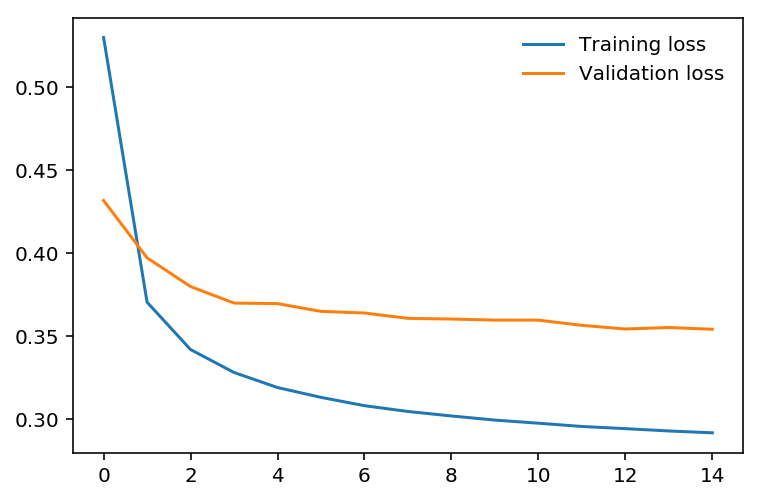

In [70]:
plt.plot(train_log, label='Training loss')
plt.plot(test_log, label='Validation loss')
plt.legend(frameon=False)

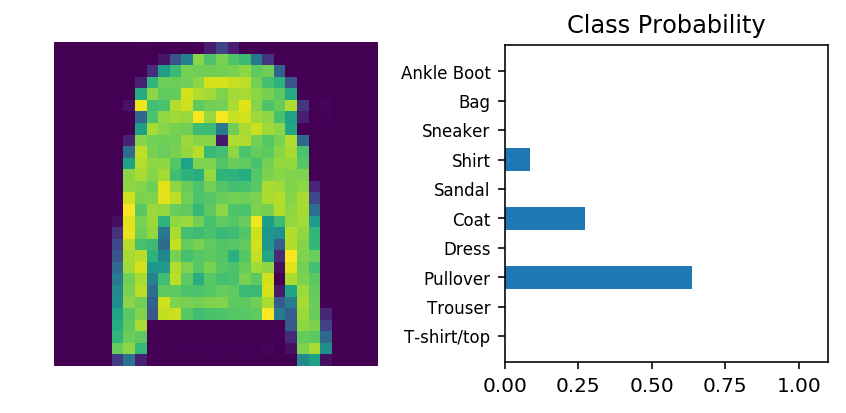

In [73]:
%config InlineBackend.figure_format = 'retina'

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

model.eval()

images, labels = next(iter(trainloader))
img = images[1].view(1, 784)

with torch.no_grad():
  output = model.forward(img)
  
ps = torch.exp(output)
view_classify(img.view(1, 28, 28), ps, version="Fashion")

## Saving & loading a model
* Save the architecture + weights + biases in a dictionary

In [0]:

# Saving a model
# print(model.state_dict().keys())

checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

# Load a model 
# checkpoint = torch.load(filepath)
# model = fc_model.Network(checkpoint['input_size'], checkpoint['output_size'],
#                              checkpoint['hidden_layers'])
# model.load_state_dict(checkpoint['state_dict'])
